# A D2Q9 Lattice Boltzmann Python implementation to simulate Toner-Tu equations

S.A.T. van Kraaij (s.a.t.v.kraaij@student.tue.nl)

April 2022, Eindhoven

[small abstract here]

---



### To do

- Implementeer density correction -> Nu genereert dit nans!
- (OK) Nieuwe equilibrium / Steady State function
- Implementeer Contact Inhibition of Locomotion
- Moeten de macroscopic vars niet alleen op (Nx, Ny) gedefinieerd zijn?


In [405]:
%reset
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pprint
import random
import time
from itertools import product

"""
Free Parameters and Physical Parameters
"""
Nx = 64 # Nodes of inner domain x-direction.
Ny = 64 # Nodes of inner domain in y-direction.
time_steps = 500 #1000 # Number of timesteps.

L = Ny # Wavelength of the initial perturbation
tau = 1 # Relaxation time, must be larger than one! Normally, this models the viscosity.
cs = np.sqrt(1/3) # Speed of sound
cs2 = cs**2
u0 = 0.02 # Characterstic velocity

"""
Constants and Lattice-Boltzmann Parameters
"""
dt = 1 # Timestep
Q = 9 # Number of neighbouring nodes
w = np.array([4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36])
e = np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]])
opposite_velocity_vector = np.array([0,3,4,1,2,7,8,5,6]) # The opposite velocity vector for the index.
t_dump = 1 # Save data once any t_dump steps.
number_of_dumps = int(time_steps/t_dump)

"""
Contact inhibition of locomotion
"""
A = 1 # A corresponds to the level of density-induced slowing down
B = 1
ux_star = np.zeros((Nx+2, Ny+2))
uy_star = np.zeros((Nx+2, Ny+2))
U0 = np.zeros((Nx+2, Ny+2))
sigma = 0.02 # Domain of uniform random sampling for random kicks.

"""
Motility-induced phase seperation
"""
# C = 10 # C>0
# rho_star = 100

# def gradient(quantity):
#     """
#     Calculate the gradient of the given quantity.
#     """
#     return np.gradient(quantity) # This is likely not correct.
    
    

'\nMotility-induced phase seperation\n'

In [406]:
def set_periodic_bc(data):
    """
    Impose the boundary conditions.
    """
    data[:,:,Ny+1] = data[:,:,1]
    data[:,:,0] = data[:,:,-2]
    data[:,0,:] = data[:,-2,:]
    data[:,Nx+1,:] = data[:,1,:]
    
    return data

# def equilibrate(rho, ux, uy):
#     """
#     Calculates the equilibrium distribution.
    
#     Params: rho (float), velocity (2D Array), q_index (int), w (1D Array), e (2D Array)
#     Return: 
#     """
#     data = np.zeros((Q,Nx+2,Ny+2))
#     for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
#         velocity_in_C_i = e[k,0]*ux[i,j] + e[k,1]*uy[i,j]
#         velocity_squared = ux[i,j]*ux[i,j]+uy[i,j]*uy[i,j]
#         data[k,i,j] = w[k]*rho[i,j]*(1+(velocity_in_C_i)/(cs**2) + (velocity_in_C_i**2)/(2*cs**4) - velocity_squared/(2*cs**2))
#     return data

def equilibrate(rho, ux, uy):
    data = np.zeros((Q,Nx+2,Ny+2))
    for i in range(Q):
        ci = e[i]
        data[i,:,:] = w[i]*rho*(1+4*(ux*ci[0]+uy*ci[1])/cs + 8*(ux*ci[0]+uy*ci[1])**2/(cs2) - 2*(ux**2+uy**2)/(cs2))
    
    return data

def calculate_steady_state(rho, ux, uy):
    """
    Calculates the non-equilibrium steady state function.

    Params: rho (float), ux (List), uy (List)
    Return: data (List)
    """
    # gradient_rho = gradient(rho);
    
    # for i,j in product(range(1,Nx+1), range(1,Ny+1)):

    #     ux_star[i,j] = C*(1-rho[i,j]/rho_star)*gradient_rho[i,j] if rho[i,j]<rho_star else 0
    #     uy_star[i,j] = C*(1-rho[i,j]/rho_star)*gradient_rho[i,j] if rho[i,j]<rho_star else 0

    # TODO: This can be done faster!
    for i,j in product(range(1,Nx+1), range(1,Ny+1)):
        
        U0 = B-A*rho[i,j]**2 if B>=A*rho[i,j]**2 else 0

        # if B>A*rho[i,j]**2:
        #     U0 = B-A*rho[i,j]**2
            
        perform_sanity_check(U0)

        # prefactor = 1/np.sqrt(ux[i,j]**2 + uy[i,j]**2 + 1e-16)

        # perform_sanity_check(prefactor)

        # if np.isinf(prefactor):
        #     print("prefactor is inf!")
        #     prefactor = 1e16

        # ux_star[i,j] = U0*prefactor*ux[i,j]
        # uy_star[i,j] = U0*prefactor*uy[i,j]

        ux_star[i,j] = U0*np.sign(ux[i,j])
        uy_star[i,j] = U0*np.sign(uy[i,j])

        perform_sanity_check(ux_star)

        perform_sanity_check(uy_star)

    # ux_star = ux
    # uy_star = uy

    return equilibrate(rho,ux_star,uy_star)

def perform_sanity_check(quantity):
    """
    Perform a sanity check by looking up any nans that might be in the quantity under investigation.

    Params: quantity (mixed)
    Return: quantity (mixed)
    """
    if np.any(np.isnan(quantity)):
        raise ValueError("quantity contains a nan at iteration "+str(t_step))
    
    return quantity

In [407]:
"""
rho contains the macroscopic densities on each lattice point.
"""
rho = np.ones((Nx+2, Ny+2))

"""
ux contains the velocity component in the x-direction.
"""
ux = np.zeros((Nx+2, Ny+2))

"""
uy contains the velocity component in the y-direction.
"""
uy = np.zeros((Nx+2, Ny+2))

"""
rhoux contains the product rho and ux on each lattice point.
"""
# rhoux=np.zeros([Q,Nx+2,Ny+2])

"""
rhouy contains the product rho and uy on each lattice point.
"""
# rhouy=np.zeros([Q,Nx+2,Ny+2])

"""
f contains the distribution on each lattice point.
"""
f = np.zeros((Q, Nx+2, Ny+2))

"""
fp contains the gathered distribution on each lattice point.
"""
fp = np.zeros((Q, Nx+2, Ny+2))

"""
feq contains the equilibrated distribution on each lattice point.
"""
feq = np.zeros((Q, Nx+2, Ny+2))

"""
Initial Condition that are nonzero
"""
ux = np.random.uniform(-0.1, 0.1, size=(Nx+2,Ny+2))
uy = np.random.uniform(-0.1, 0.1, size=(Nx+2,Ny+2))
# ux = np.zeros((Nx+2,Ny+2))
# uy = np.zeros((Nx+2,Ny+2))

"""
Initialize the particle distribution f
"""
feq = perform_sanity_check( calculate_steady_state(rho, ux, uy) )
f = feq

"""
The following variables will be used as storage for the horizontal and vertical velocity, the density and the location of the maximum velocity. These variables will be updated every t_dump timesteps.
"""
ux_history = np.zeros((number_of_dumps,Nx+2, Ny+2))
uy_history = np.zeros((number_of_dumps,Nx+2, Ny+2))
rho_history = np.zeros((number_of_dumps,Nx+2, Ny+2))

## Main time loop

In [408]:
start_time = time.time()
dump_counter = 0;

for t_step in range(time_steps):
    
    """
    Apply the periodic boundary condition to f.
    """
    set_periodic_bc(f)
        
    """
    Stream/gather step
    """
    for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
        fp[k,i,j] = f[k, i-e[k,0], j-e[k,1]]

    """
    Sanity check of fp
    """
    perform_sanity_check(fp)

    """
    Calculate the macroscopic density and the velocities.
    """
    rho = np.sum(fp, axis=0)
    ux = np.transpose(np.sum(np.transpose(fp)*e[:,0],axis=2))
    uy = np.transpose(np.sum(np.transpose(fp)*e[:,1],axis=2))

    """
    Sanity check of macroscopic quantities.
    """
    perform_sanity_check(rho)
    perform_sanity_check(ux)
    perform_sanity_check(uy)

    """
    Save macroscopic entities once every t_dump steps.
    """
    if t_step%t_dump == 0:
        print("t_step = "+str(t_step),end='\r')
        rho_history[dump_counter,:,:] = rho
        ux_history[dump_counter,:,:] = ux
        uy_history[dump_counter,:,:] = uy

        dump_counter += 1

    """
    Calculate new equilibrium.
    """
    feq = calculate_steady_state(rho, ux, uy)

    """
    Sanity check of feq.
    """
    perform_sanity_check(feq)

    """
    Generate noise
    """
    noise = np.random.uniform(-sigma,sigma, size=(Q, Nx+2, Ny+2)) # Pluck values from uniform distribution.
    # noise[0] = (-1/Q)*np.sum(noise[1:-1],axis=0)
    corrected_noise = noise - (1/Q)*np.sum(noise, axis=0)

    """
    Collision step
    """
    for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
        f[k,i,j] = fp[k,i,j]-(1/tau)*(fp[k,i,j]-feq[k,i,j]) + corrected_noise[k,i,j]

    """
    Negative f correction
    """
    for k,i,j in product(range(Q), range(1,Nx+1), range(1,Ny+1)):
        """
        Set f[0,i,j] to zero if value is negative.
        """
        if k==0 and f[0,i,j]<0:
            f[0,i,j] = 0

        """
        Correct f[k,i,j] for all k>0.
        """
        if k>0 and f[k,i,j]<0:
            """
            From David Nesbitt, 2021:
            If f_i<0 for i>0 then take j, such that e_j is the reverse direction of e_i and add |f_i| to f_j and set f_i=0
            """
            f[opposite_velocity_vector[k],i,j] += np.abs(f[k,i,j])
            f[k,i,j] = 0

    perform_sanity_check(f)

    """
    Density correction
    """
    f = (rho/np.sum(f, axis=0))*f

    """
    Sanity check of f 
    """
    perform_sanity_check(f)

print ('Elapsed Time : ', time.time() - start_time, 'seconds')


[[-1.73472348e-18 -3.46944695e-18  1.73472348e-18 ...  1.95156391e-18
  -1.73472348e-18  0.00000000e+00]
 [ 6.93889390e-18 -5.20417043e-18 -3.46944695e-18 ...  0.00000000e+00
  -3.46944695e-18  6.93889390e-18]
 [-6.93889390e-18  6.93889390e-18 -6.93889390e-18 ...  6.07153217e-18
  -5.20417043e-18 -6.93889390e-18]
 ...
 [-1.73472348e-18  6.93889390e-18  8.67361738e-18 ... -1.04083409e-17
   6.07153217e-18 -7.80625564e-18]
 [-3.46944695e-18 -6.93889390e-18  3.46944695e-18 ... -3.46944695e-18
   0.00000000e+00 -3.46944695e-18]
 [-6.07153217e-18  4.33680869e-18  3.46944695e-18 ...  3.46944695e-18
   3.46944695e-18  7.80625564e-18]]
[[-1.12757026e-17 -1.21430643e-17 -3.46944695e-18 ... -3.46944695e-18
   9.54097912e-18  3.46944695e-18]
 [ 6.93889390e-18 -3.46944695e-18 -6.93889390e-18 ...  8.67361738e-18
  -1.73472348e-18  3.46944695e-18]
 [ 7.80625564e-18  0.00000000e+00  6.93889390e-18 ...  5.20417043e-18
  -3.46944695e-18  0.00000000e+00]
 ...
 [-6.93889390e-18  0.00000000e+00 -1.0408340

KeyboardInterrupt: 

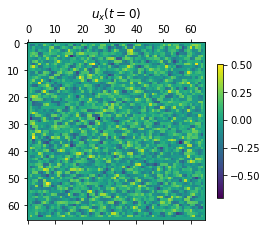

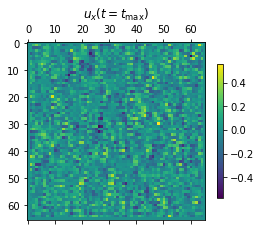

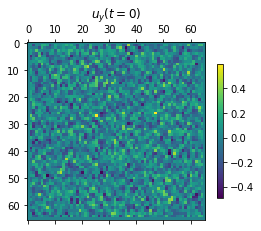

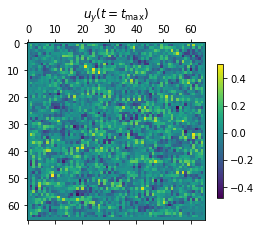

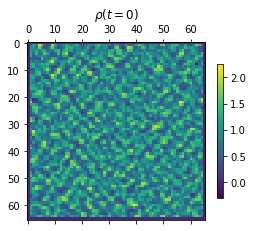

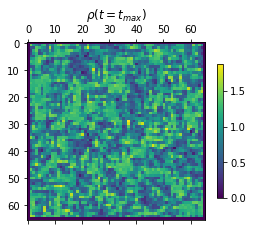

'\nTime series\n'

In [ ]:

ux_hist_t0 = plt.matshow(ux_history[1,:,:])
plt.colorbar(ux_hist_t0, shrink=0.6)
plt.title("$u_x(t=0)$")
plt.show()

ux_hist_tmax = plt.matshow(ux_history[-1,:,:])
plt.colorbar(ux_hist_tmax, shrink=0.6)
plt.title("$u_x(t=t_\mathrm{max})$")
plt.show()

uy_hist_t0 = plt.matshow(uy_history[1,:,:])
plt.colorbar(uy_hist_t0, shrink=0.6)
plt.title("$u_y(t=0)$")
plt.show()

uy_hist_tmax = plt.matshow(uy_history[-1,:,:])
plt.colorbar(uy_hist_tmax, shrink=0.6)
plt.title("$u_y(t=t_\mathrm{max})$")
plt.show()

rho_hist_t0 = plt.matshow(rho_history[1,:,:])
plt.colorbar(rho_hist_t0, shrink=0.6)
plt.title(r"$\rho(t=0)$")
plt.show()

rho_hist_tmax = plt.matshow(rho_history[-1,:,:])
plt.colorbar(rho_hist_tmax, shrink=0.6)
plt.title(r"$\rho(t=t_{max})$")
plt.show()

"""
Time series
"""
# numerical_contourplot = []
# for i in range(time_steps):
#     numerical_contourplot.append( plt.matshow(ux_history[i,:,:],vmin=-1,vmax=1) )
#     plt.colorbar(numerical_contourplot[i], shrink=0.6)
#     plt.title("time step ="+str(i))
# plt.xlabel("x")
# plt.ylabel("y")
# plt.xlim(1,Nx)
# plt.ylim(1,Ny)

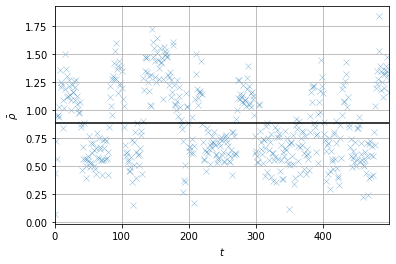

/var/folders/qb/kz2h3qwj4qqg8yl1shdvlnkr0000gn/T/ipykernel_31041/593346638.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([min(time_series), max(time_series)])


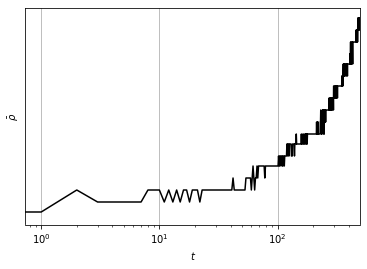

In [ ]:
"""
Calculate and plot mean density
"""
rho_mean_history = np.mean(rho_history, axis=(1,2))
time_series = range(0,time_steps)
plt.plot(time_series,rho_mean_history, color='black')
plt.scatter(time_series, rho_history[:,int(Nx/2),int(Ny/2)], alpha=0.5, marker='x', linewidths=0.5)
plt.ylabel(r'$\bar{\rho}$')
plt.xlabel(r'$t$')
plt.grid()
plt.xlim([min(time_series), max(time_series)])
plt.show()

"""
Calculate and plot mean density
"""
rho_mean_history = np.mean(rho_history, axis=(1,2))
time_series = range(0,time_steps)
plt.loglog(time_series,rho_mean_history, color='black')
plt.ylabel(r'$\bar{\rho}$')
plt.xlabel(r'$t$')
plt.grid()
plt.xlim([min(time_series), max(time_series)])
plt.show()

## Animation

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(15,15))

image = ax.matshow(ux_history[0,:,:])
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(ux_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save("animation_ux.mp4")


<IPython.core.display.Javascript object>

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(15,15))

image = ax.matshow(uy_history[0,:,:])
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(uy_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save("animation_uy.mp4")


<IPython.core.display.Javascript object>

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(15,15))

image = ax.matshow(rho_history[0,:,:])
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(rho_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save("animation_rho.mp4")


<IPython.core.display.Javascript object>